In [ ]:
!pip install remotezip tqdm opencv-python einops
!pip install -U tensorflow keras
!pip install pytubefix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 7.6 MB/s eta 0:00:00


In [ ]:
import tqdm
import random
import itertools
import collections
import requests
import zipfile
import shutil

import cv2
import os
import einops
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from io import BytesIO
from remotezip import RemoteZip as rz
from pathlib import Path
from collections import deque, defaultdict
from keras import layers
from moviepy.editor import *
from pytubefix import YouTube
from pytubefix.cli import on_progress
%matplotlib inline

  if event.key is 'enter':



In [ ]:
#@title
def download_and_extract_zip(zip_url, extract_to):
    """
    Download a ZIP file from a URL and extract its contents.

    Args:
        zip_url (str): The URL of the ZIP file.
        extract_to (str): The directory where the contents should be extracted.

    Returns:
        extracted_files (list): List of extracted file paths.
    """
    response = requests.get(zip_url)
    with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
        zip_ref.extractall(extract_to)
    extracted_files = [str(p) for p in Path(extract_to).rglob('*') if p.is_file()]
    return extracted_files

def split_files(files, split_ratio=0.8):
    """
    Split files into training and test sets based on a ratio.

    Args:
        files (list): List of file paths.
        split_ratio (float): Ratio of files to include in the training set.

    Returns:
        train_files (list): List of training files.
        test_files (list): List of test files.
    """
    random.shuffle(files)
    split_index = int(len(files) * split_ratio)
    return files[:split_index], files[split_index:]

def organize_files_by_name(train_files, test_files, train_dir, test_dir):
    """
    Organize files into training and test directories based on their names.

    Args:
        train_files (list): List of training file paths.
        test_files (list): List of test file paths.
        train_dir (str): Directory for training files.
        test_dir (str): Directory for test files.
    """
    for f in train_files:
        class_name = Path(f).stem.split('_')[1]
        train_class_dir = Path(train_dir) / class_name
        train_class_dir.mkdir(parents=True, exist_ok=True)
        shutil.move(f, train_class_dir / Path(f).name)

    for f in test_files:
        class_name = Path(f).stem.split('_')[1]
        test_class_dir = Path(test_dir) / class_name
        test_class_dir.mkdir(parents=True, exist_ok=True)
        shutil.move(f, test_class_dir / Path(f).name)

def process_dataset(zip_url, download_dir, split_ratio=0.8):
    """
    Download a ZIP file, extract it, split the dataset, and organize into directories.

    Args:
        zip_url (str): The URL of the ZIP file.
        download_dir (str): The directory where the dataset should be organized.
        split_ratio (float): Ratio of files to include in the training set.

    Returns:
        None
    """
    extract_to = Path(download_dir) / 'extracted'
    train_dir = Path(download_dir) / 'train'
    test_dir = Path(download_dir) / 'test'

    # Download and extract the dataset
    extracted_files = download_and_extract_zip(zip_url, extract_to)

    # Split the files into training and test sets
    train_files, test_files = split_files(extracted_files, split_ratio)

    # Organize the files into their respective directories
    organize_files_by_name(train_files, test_files, train_dir, test_dir)

    # Clean up extracted files directory
    shutil.rmtree(extract_to)

    print(f"Dataset organized into:\nTrain directory: {train_dir}\nTest directory: {test_dir}")

    return {
        'train': str(train_dir),
        'test': str(test_dir)
    }

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 20):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [ ]:
URL = 'https://firebasestorage.googleapis.com/v0/b/nomadic-memento-423612-j6.appspot.com/o/Dataset_videos.zip?alt=media&token=8aa37c3a-32b9-4004-a1f0-04326362d4bc'
download_dir = 'Dataset_Subset'
subset_paths = process_dataset(zip_url=URL, download_dir=download_dir, split_ratio=0.8)

Dataset organized into:
Train directory: Dataset_Subset/train
Test directory: Dataset_Subset/test


In [ ]:
n_frames = 20
batch_size = 8
train_path = Path(subset_paths['train'])
test_path = Path(subset_paths['test'])

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

# Batch the data
train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_path, n_frames, training=True),
                                          output_signature = output_signature)

train_ds = train_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_path, n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

In [ ]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [ ]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension.
    """
    super().__init__()
    self.seq = keras.Sequential([
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

In [ ]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [ ]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different
    sized filters and downsampled.
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [ ]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters,
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [ ]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height,
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [ ]:
def create_functional_model():
    input_shape = (None, 20, HEIGHT, WIDTH, 3)
    input = layers.Input(shape=(input_shape[1:]))
    x = input

    x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

    # Block 1
    x = add_residual_block(x, 16, (3, 3, 3))
    x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

    # Block 2
    x = add_residual_block(x, 32, (3, 3, 3))
    x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

    # Block 3
    x = add_residual_block(x, 64, (3, 3, 3))
    x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

    # Block 4
    x = add_residual_block(x, 128, (3, 3, 3))

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(10)(x)

    model = keras.Model(input, x)
    return model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model=create_functional_model()
model.load_weights("/content/drive/MyDrive/MOdel SKripsSI/model_SGD20.h5")

In [ ]:
#model=create_functional_model()
frames, label = next(iter(train_ds))
model.build(frames)

In [ ]:
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 20, 224, 224,   │              0 │ -                      │
│                           │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_plus1d              │ (None, 20, 224, 224,   │          3,152 │ input_layer[0][0]      │
│ (Conv2Plus1D)             │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 20, 224, 224,   │             64 │ conv2_plus1d[0][0]     │
│ (BatchNormalization)      │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 20, 224, 224,   │              0 │ batch_normalization[0… │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_video              │ (None, 20, 112, 112,   │              0 │ re_lu[0][0]            │
│ (ResizeVideo)             │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_main             │ (None, 20, 112, 112,   │          6,272 │ resize_video[0][0]     │
│ (ResidualMain)            │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 20, 112, 112,   │              0 │ resize_video[0][0],    │
│                           │ 16)                    │                │ residual_main[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_video_1            │ (None, 20, 56, 56, 16) │              0 │ add[0][0]              │
│ (ResizeVideo)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ project (Project)         │ (None, 20, 56, 56, 32) │            608 │ resize_video_1[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_main_1           │ (None, 20, 56, 56, 32) │         20,224 │ resize_video_1[0][0]   │
│ (ResidualMain)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 20, 56, 56, 32) │              0 │ project[0][0],         │
│                           │                        │                │ residual_main_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_video_2            │ (None, 20, 28, 28, 32) │              0 │ add_1[0][0]            │
│ (ResizeVideo)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ project_1 (Project)       │ (None, 20, 28, 28, 64) │          2,240 │ resize_video_2[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_main_2           │ (None, 20, 28, 28, 64) │         80,384 │ resize_video_2[0][0]   │
│ (ResidualMain)       

 Total params: 443,322 (1.69 MB)

 Trainable params: 443,290 (1.69 MB)

 Non-trainable params: 32 (128.00 B)

In [ ]:
model = create_functional_model()
frames, label = next(iter(train_ds))
model.build(frames)

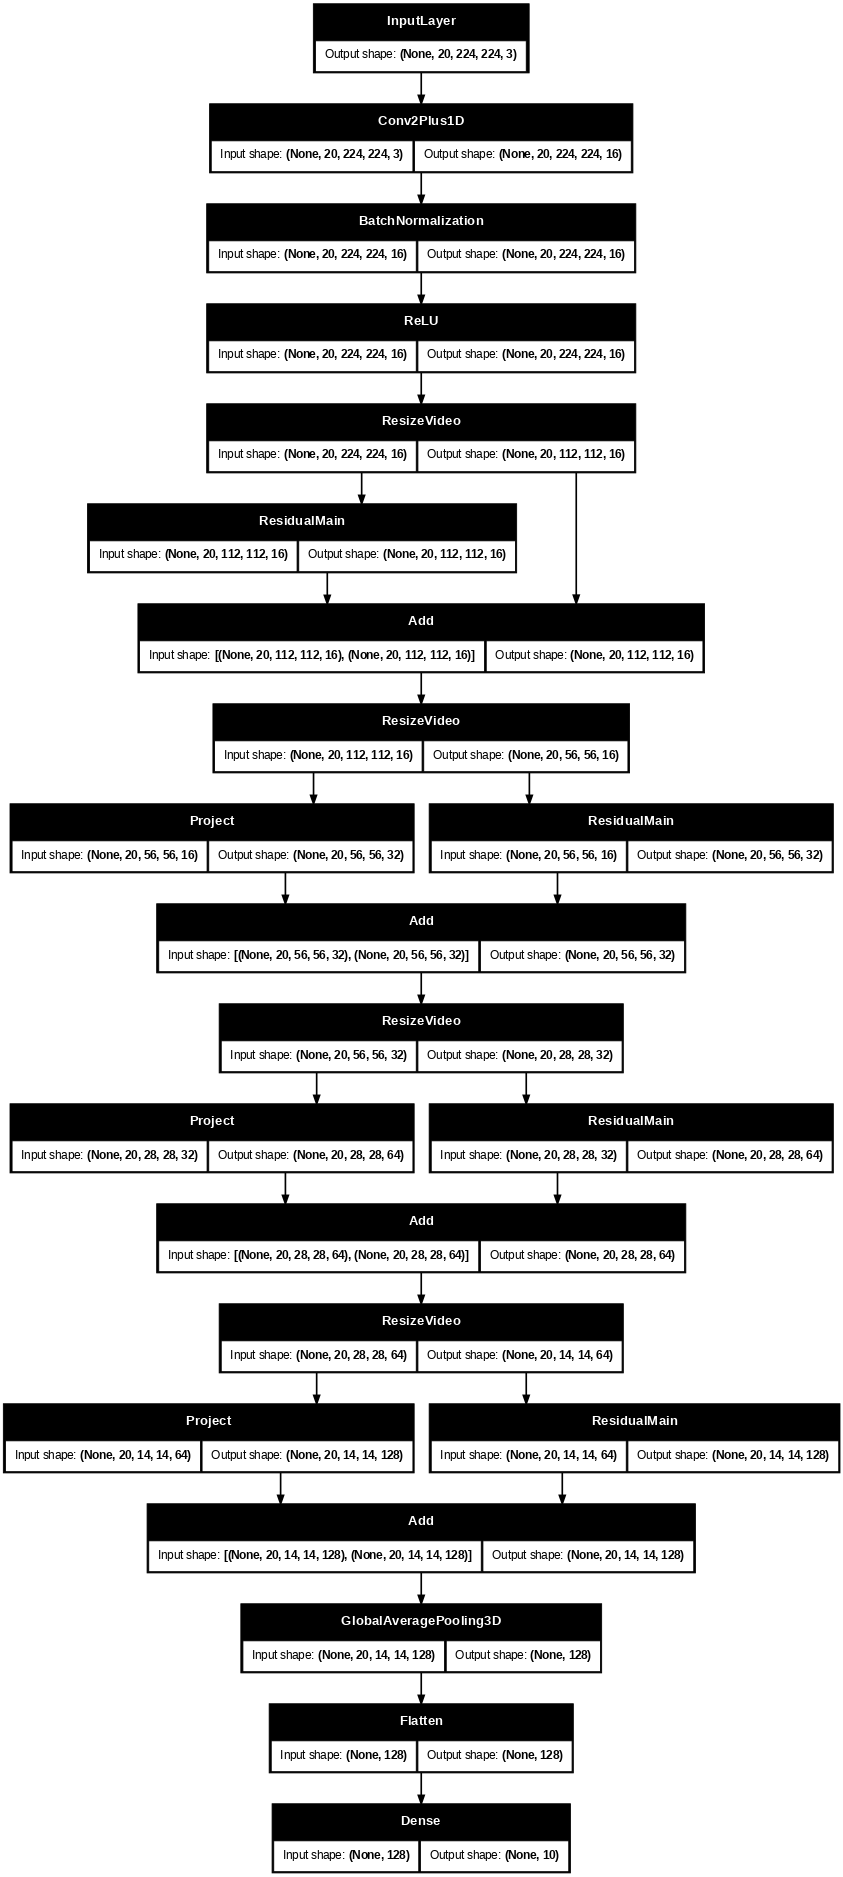

In [ ]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [ ]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = keras.optimizers.SGD(learning_rate = 0.0001),
              metrics = ['accuracy'])

In [ ]:
history = model.fit(x = train_ds,
                    epochs = 100,
                    validation_data = test_ds)

Epoch 1/100
     14/Unknown 65s 2s/step - accuracy: 0.1731 - loss: 2.1959

  self.gen.throw(typ, value, traceback)



15/15 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.1973 - loss: 2.1310 - val_accuracy: 0.5161 - val_loss: 1.2443
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.4621 - loss: 1.0405 - val_accuracy: 0.5161 - val_loss: 0.9676
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.4199 - loss: 0.9018 - val_accuracy: 0.5484 - val_loss: 0.7957
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.5237 - loss: 0.7895 - val_accuracy: 0.5484 - val_loss: 0.7636
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.5438 - loss: 0.7686 - val_accuracy: 0.5161 - val_loss: 0.7512
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.5108 - loss: 0.7437 - val_accuracy: 0.4839 - val_loss: 0.7381
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.5872 - loss: 0.7142 - val_accuracy: 0.4516 - val_loss: 0.7349
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.5730 - loss: 0.6843 - val_accuracy: 0.4516 - val_loss: 0.7

In [ ]:
model.save('/model_SGD20.keras')
model.save('/model_SGD20.h5')

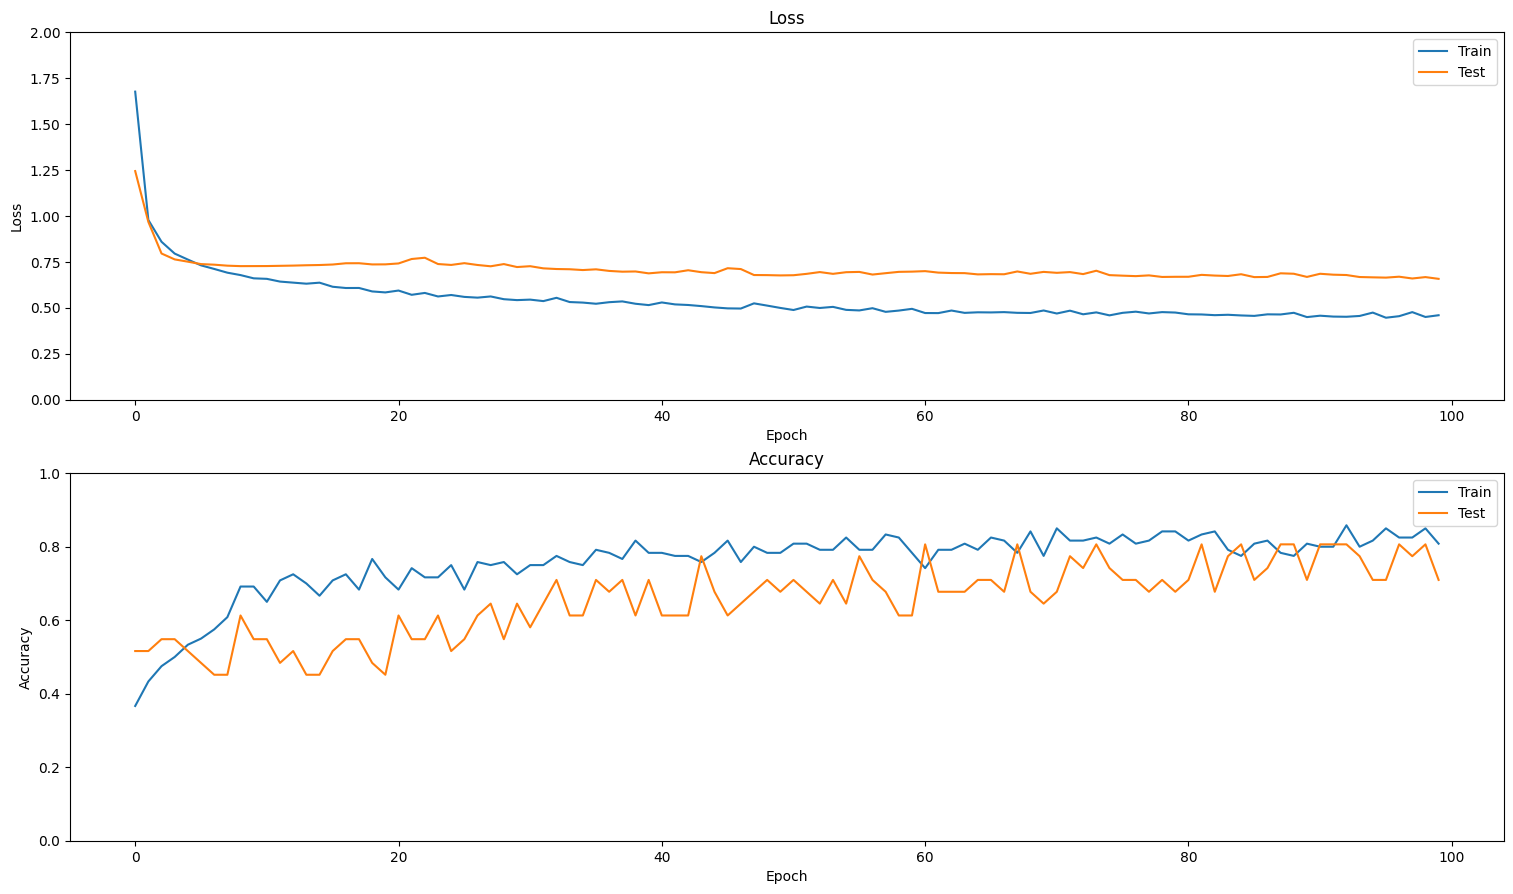

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Test'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Test'])

  plt.show()

plot_history(history)

In [ ]:
model.evaluate(test_ds, return_dict=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7130 - loss: 0.6921


{'accuracy': 0.7096773982048035, 'loss': 0.6578531861305237}

In [ ]:
 !nvidia-smi

Wed Oct 23 15:14:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0              30W /  70W |   6361MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.170
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmi

In [ ]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [ ]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [ ]:
fg = FrameGenerator(train_path, n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step


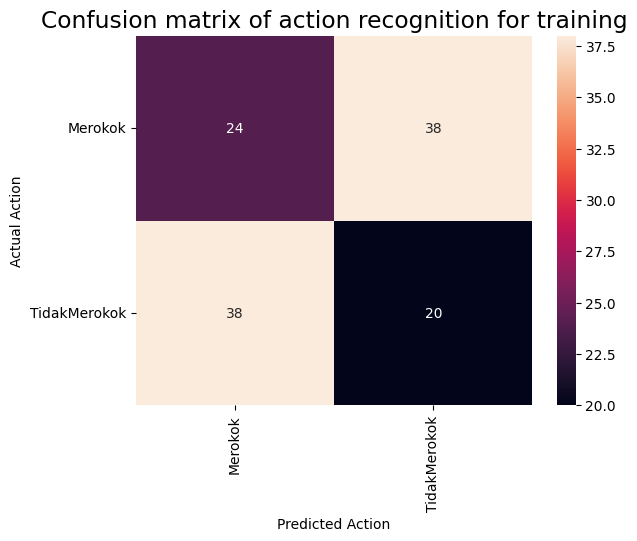

In [ ]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

      4/Unknown 14s 4s/step

  self.gen.throw(typ, value, traceback)



4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step


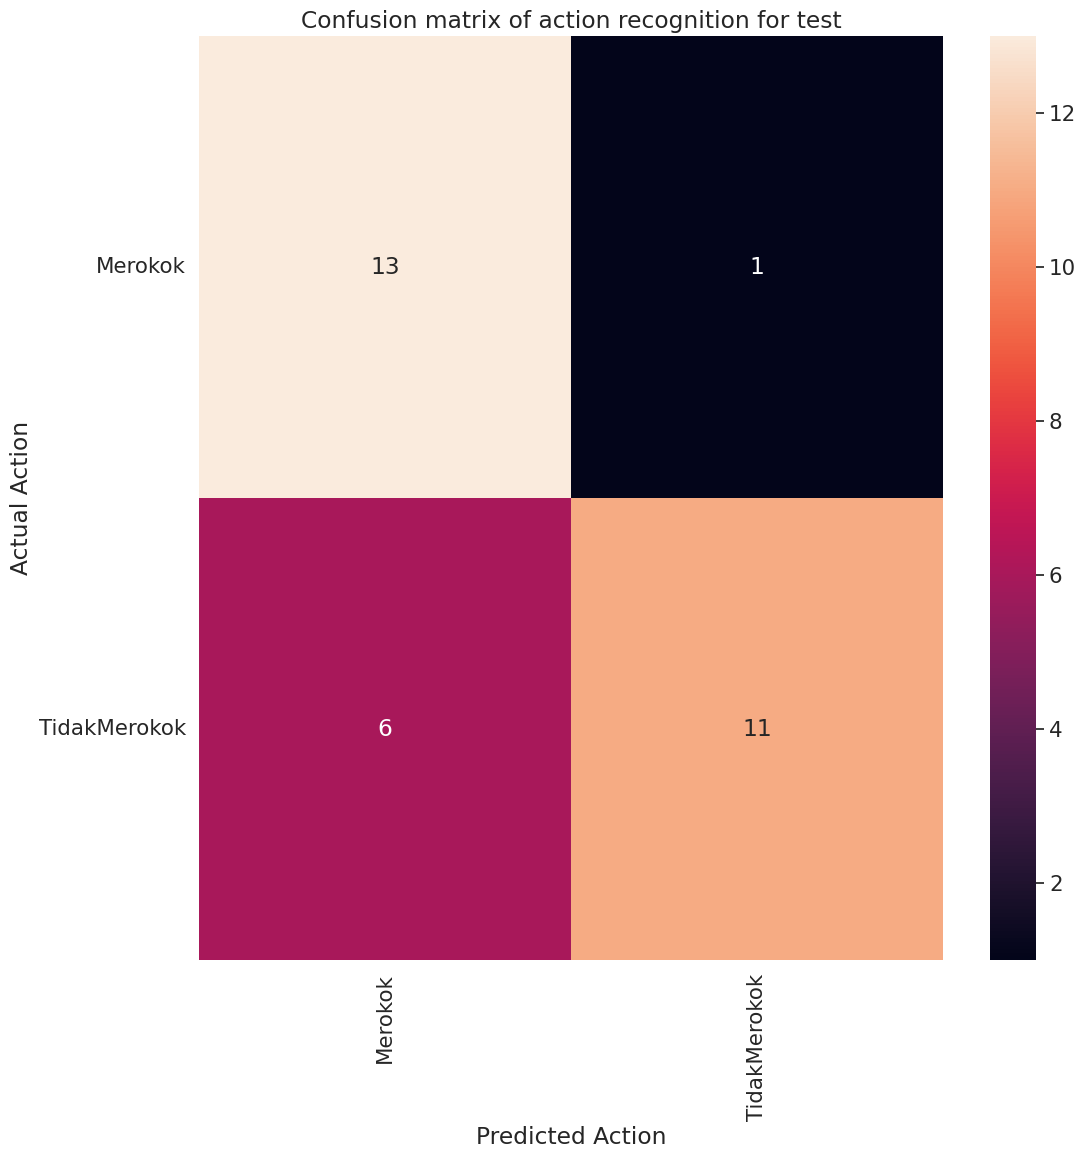

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [ ]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values.

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  f1_score = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

    f1_score[labels[i]] = 2 * ((precision[labels[i]] * recall[labels[i]]) / (precision[labels[i]] + recall[labels[i]]))

  return precision, recall, f1_score

In [ ]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values.

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  f1_score = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

    f1_score[labels[i]] = 2 * ((precision[labels[i]] * recall[labels[i]]) / (precision[labels[i]] + recall[labels[i]]))

  return precision, recall, f1_score

In [ ]:
precision, recall, f1_score = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [ ]:
precision, recall, f1_score = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [ ]:
precision

In [ ]:
precision

{'Merokok': 0.6842105263157895, 'TidakMerokok': 0.9166666666666666}

In [ ]:
recall

In [ ]:
recall

{'Merokok': 0.9285714285714286, 'TidakMerokok': 0.6470588235294118}

In [ ]:
f1_score

{'Merokok': 0.7878787878787878, 'TidakMerokok': 0.7586206896551724}

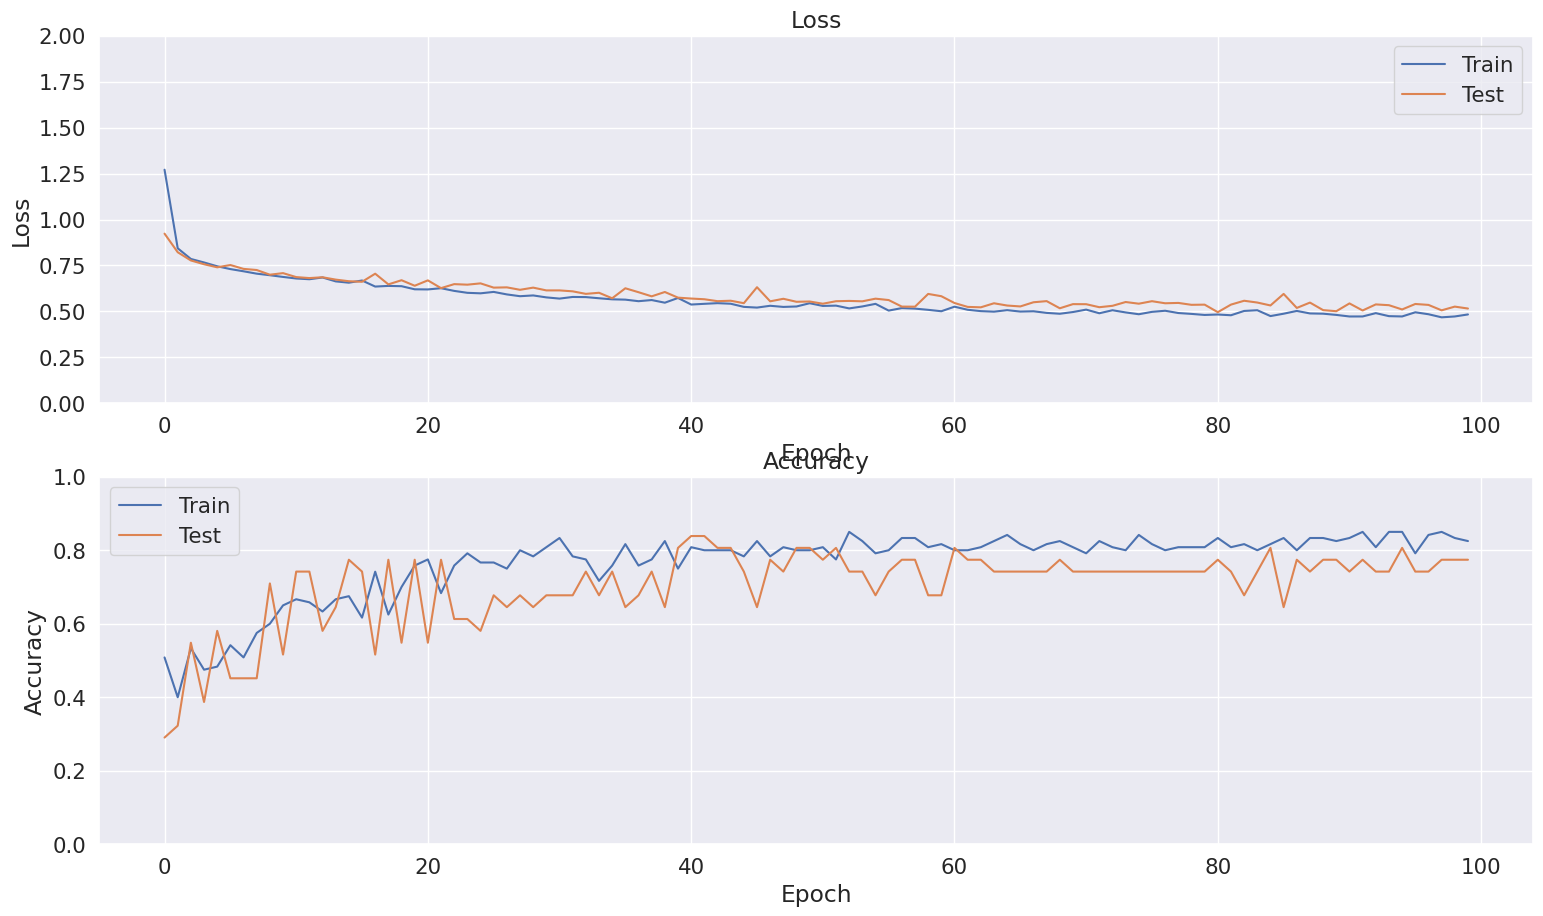

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Test'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Test'])

  plt.show()

plot_history(history)

In [ ]:
def download_youtube_videos(yt_video_url, output_directory):
    video=YouTube(yt_video_url)
    judul=video.title
    video_best=video.streams.get_highest_resolution()
    video_best.download(output_directory)
    return judul

In [ ]:
CLASSES_LIST=["Merokok", "Tidak Merokok"]

In [ ]:
def calculate_brightness_contrast(frame):
    """
    Menghitung kecerahan dan kontras dari sebuah frame.

    Parameters:
    - frame: Frame video dalam format RGB atau grayscale.

    Returns:
    - brightness: Rata-rata kecerahan frame.
    - contrast: Kontras frame.
    """
    # Convert to grayscale if it's a colored frame
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Brightness is the mean pixel value
    brightness = np.mean(gray_frame)

    # Contrast is the standard deviation of pixel values
    contrast = np.std(gray_frame)

    return brightness, contrast

def predict_on_video(video_file_path, output_file_path, n_frames):
    '''
    Prediksi video dan menyimpan video yg sdh diberi prediksi overlay
    dan juga menghitung kecerahan serta kontras rata-rata.

    Parameters:
    - video_file_path: Path of the video stored on the disk on which the action recognition is performed.
    - output_file_path: Path where the output video with predicted action overlayed will be stored.
    - n_frames: Fixed number of frames in the video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Check if the video file was successfully opened.
    if not video_reader.isOpened():
        raise IOError(f"Error opening video file: {video_file_path}")

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize VideoWriter object to store the output video.
    video_writer = cv2.VideoWriter(
        output_file_path,
        cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
        video_reader.get(cv2.CAP_PROP_FPS),
        (original_video_width, original_video_height)
    )

    # Declare a deque to store video frames. menyimpan frame ke model
    frames_queue = deque(maxlen=n_frames)

    # menghitung jumlah prediksi kelas.
    predicted_classes_count = {class_name: 0 for class_name in CLASSES_LIST}  # Replace CLASSES_LIST with your actual class list

    # Initialize variables to store brightness and contrast.
    total_brightness = 0
    total_contrast = 0
    frame_count = 0

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = '' #menyimpan nama kelas yang diprediksi
    predicted_probability = 0.0 #menyimpan probabilitas predksi

    # Set dynamic font size and thickness based on video resolution
    font_scale = original_video_width / 400  # skala font
    font_thickness = int(original_video_width / 500)  # tebal font

    # Variable to hold the last frame (for displaying final summary).
    last_frame = None

    # Maximum number of text lines that can fit vertically in the video frame.
    max_lines = int(original_video_height // (font_scale * 40))  #how many lines of text can fit

    # Process each frame of the video.
    while video_reader.isOpened():
        ok, frame = video_reader.read()
        if not ok:
            break

        # Keep track of the last frame.
        last_frame = frame.copy()

        # Calculate brightness and contrast for the frame.
        brightness, contrast = calculate_brightness_contrast(frame)
        total_brightness += brightness
        total_contrast += contrast
        frame_count += 1

        # Resize and normalize the frame.
        resized_frame = cv2.resize(frame, (WIDTH, HEIGHT))  # Replace WIDTH and HEIGHT with actual values
        normalized_frame = resized_frame / 255.0
        frames_queue.append(normalized_frame)

        # Make a prediction when the queue is full.
        if len(frames_queue) == n_frames:
            predicted_labels_probabilities = model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]  # Replace CLASSES_LIST with your actual class list
            predicted_probability = predicted_labels_probabilities[predicted_label]

            # Increment the count of the predicted class.
            predicted_classes_count[predicted_class_name] += 1

        # Overlay the predicted class name and probability on the frame.
        overlay_text = f'{predicted_class_name}: {predicted_probability:.2f}'
        text_position = (int(original_video_width * 0.01), int(original_video_height * 0.05))

        cv2.putText(frame, overlay_text, text_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 0, 0), font_thickness)

        # Overlay the count of all predicted classes.
        y_position = int(original_video_height * 0.1)  # Starting y position
        line_counter = 1  # To track how many lines have been printed

        # Write the frame with the overlayed prediction to the output video.
        video_writer.write(frame)

    # After processing all frames, determine the class with the highest count.
    max_class_name = max(predicted_classes_count, key=predicted_classes_count.get)
    max_count = predicted_classes_count[max_class_name]

    # If the max count is greater than 50, add the summary to the last frame.
    if last_frame is not None and max_count > 50:
        summary_text = f'Diprediksi {max_class_name} dengan jumlah {max_count} per 15 frame'
        y_position = int(original_video_height * 0.05)  # Starting y position for summary

        # Check if adding the summary text would exceed the bottom of the frame.
        if y_position + int(font_scale * 40) > original_video_height:
            y_position = int(original_video_height - int(font_scale * 40))  # Adjust to prevent text from going off screen

        cv2.putText(last_frame, summary_text, (int(original_video_width * 0.01), y_position),
                    cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), font_thickness)

        # Write the final frame with the summary.
        video_writer.write(last_frame)

    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

    # Calculate average brightness and contrast over all frames.
    average_brightness = total_brightness / frame_count
    average_contrast = total_contrast / frame_count

    # Print out the count of each predicted class and brightness/contrast info.
    print(f"Disave pada {output_file_path}")
    print("Prediksi tiap kelasnya:")
    for class_name, count in predicted_classes_count.items():
        print(f"{class_name}: {count}")
    print(f"Diprediksi {max(predicted_classes_count, key=predicted_classes_count.get)}")
    print(f"Kecerahan rata-rata: {average_brightness:.2f}")
    print(f"Kontras rata-rata: {average_contrast:.2f}")


In [ ]:
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok=True)
video1_judul=download_youtube_videos('https://youtu.be/xzMpmb56QHA?si=zL9pDozFNeU0FafD', test_videos_directory)
input1_video_file_path=f'{test_videos_directory}/{video1_judul}.mp4'

In [ ]:
#prediksi kegiatan banyak
video1_judul=download_youtube_videos('https://youtu.be/xzMpmb56QHA?si=zL9pDozFNeU0FafD', test_videos_directory)
output1_video_file_path=f'{test_videos_directory}/{video1_judul}-Output-frame{n_frames}.mp4'
predict_on_video(input1_video_file_path, output1_video_file_path, n_frames)
VideoFileClip(output1_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

Moviepy - Done !
Moviepy - video ready __temp__.mp4
